In [21]:
import struct
import numpy as np
import intvalpy as ip
from functools import cmp_to_key
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
def read_bin_file_with_numpy(file_path):
  with open(file_path, 'rb') as f:
    header_data = f.read(256)
    side, mode, frame_count = struct.unpack('<BBH', header_data[:4])

    frames = []
    point_dtype = np.dtype('<8H')

    for _ in range(frame_count):
      frame_header_data = f.read(16)
      stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
      frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
      frames.append(frame_data)

    return np.array(frames)

In [23]:
def convert_to_voltage(data):
  return data / 16384.0 - 0.5

In [24]:
def are_intersected(x, y):
  sup = y.a if x.a < y.a else x.a
  inf = x.b if x.b < y.b else y.b
  return sup - inf <= 1e-15

In [25]:
def are_adjusted_to_each_other(x, y):
  return x.b == y.a or y.b == x.a

In [26]:
def merge_intervals(x, y):
  return ip.Interval(min(x.a, y.a), max(x.b, y.b))

In [27]:
def mode(x):
  if len(x) == 0:
    return []

  edges = sorted({x_i.a for x_i in x}.union({x_i.b for x_i in x}))
  z = [ip.Interval(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
  mu = [sum(1 for x_i in x if z_i in x_i) for z_i in z]

  max_mu = max(mu)
  K = [index for index, element in enumerate(mu) if element == max_mu]

  m = [z[k] for k in K]
  merged_m = []

  current_interval = m[0]

  for next_interval in m[1:]:
    if are_intersected(current_interval, next_interval) or are_adjusted_to_each_other(current_interval, next_interval):
      current_interval = merge_intervals(current_interval, next_interval)
    else:
      merged_m.append(current_interval)
      current_interval = next_interval

  merged_m.append(current_interval)

  return merged_m

In [28]:
def med_k(x):
  starts = [float(interval.a) for interval in x]
  ends = [float(interval.b) for interval in x]
  return ip.Interval(np.median(starts), np.median(ends))

In [29]:
def med_p(x):
  x = sorted(x, key=cmp_to_key(lambda x, y: (x.a + x.b) / 2 - (y.a + y.b) / 2))

  mid_index = len(x) // 2

  if len(x) % 2 == 0:
    return (x[mid_index - 1] + x[mid_index]) / 2

  return x[mid_index]

In [30]:
def jaccard_index(*args):
  if len(args) == 1:
    x = args[0]
    left_edges = [interval.a for interval in x]
    right_edges = [interval.b for interval in x]

    return (min(right_edges) - max(left_edges)) / (max(right_edges) - min(left_edges))
  elif len(args) == 2:
    x = args[0]
    y = args[1]

    if isinstance(x, ip.ClassicalArithmetic) and isinstance(y, ip.ClassicalArithmetic):
      return (min(x.b, y.b) - max(x.a, y.a)) / (max(x.b, y.b) - min(x.a, y.a))
    else:
      results = []

      for x_i, y_i in zip(x, y):
        result = (min(x_i.b, y_i.b) - max(x_i.a, y_i.a)) / (max(x_i.b, y_i.b) - min(x_i.a, y_i.a))
        results.append(result)

      return np.array(results)
  else:
    raise ValueError("Wrong number of arguments")

In [31]:
def ternary_search(f, left, right, eps):
  while right - left > eps:
    m1 = left + (right - left) / 3
    m2 = right - (right - left) / 3

    if f(m1) < f(m2):
      left = m1
    else:
      right = m2

  return (left + right) / 2

In [32]:
def estimate_a(a):
  return np.mean(jaccard_index(x_voltage_int_flatten + a, y_voltage_int_flatten))

def estimate_t(t):
  return np.mean(jaccard_index(x_voltage_int_flatten * t, y_voltage_int_flatten))

def estimate_a_mode(a):
  return np.mean(jaccard_index(mode(x_voltage_int_flatten + a), mode(y_voltage_int_flatten)))

def estimate_t_mode(t):
  x = mode(x_voltage_int_flatten * t)
  x_idx = len(x) // 2
  x = x[x_idx]

  y = mode(y_voltage_int_flatten)
  y_idx = len(y) // 2
  y = y[y_idx]

  return np.mean(jaccard_index(x, y))

def estimate_a_med_p(a):
  return np.mean(jaccard_index(med_p(x_voltage_int_flatten + a), med_p(y_voltage_int_flatten)))

def estimate_t_med_p(t):
  return np.mean(jaccard_index(med_p(x_voltage_int_flatten * t), med_p(y_voltage_int_flatten)))

def estimate_a_med_k(a):
  return np.mean(jaccard_index(med_k(x_voltage_int_flatten + a), med_k(y_voltage_int_flatten)))

def estimate_t_med_k(t):
  return np.mean(jaccard_index(med_k(x_voltage_int_flatten * t), med_k(y_voltage_int_flatten)))

In [33]:
def scalar_to_interval(x, rad):
  return ip.Interval(x - rad, x + rad)
scalar_to_interval_vec = np.vectorize(scalar_to_interval)

In [34]:
x_data = read_bin_file_with_numpy('-0.205_lvl_side_a_fast_data.bin')
y_data = read_bin_file_with_numpy('0.225_lvl_side_a_fast_data.bin')

In [35]:
x_voltage = convert_to_voltage(x_data)
y_voltage = convert_to_voltage(y_data)

x_voltage = np.transpose(x_voltage, axes=(2, 1, 0))
y_voltage = np.transpose(y_voltage, axes=(2, 1,0))

<Axes: ylabel='Count'>

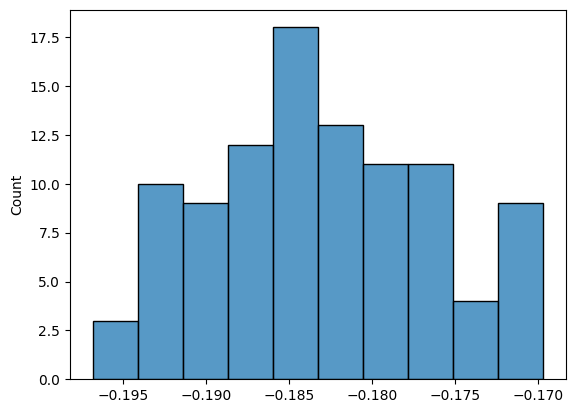

In [36]:
sns.histplot(x_voltage[0,0,:], bins=10)

<Axes: ylabel='Count'>

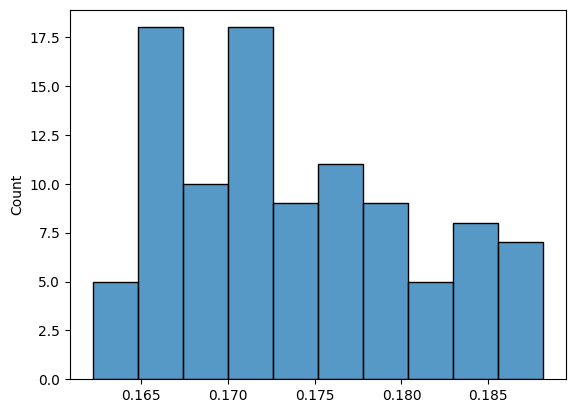

In [37]:
sns.histplot(y_voltage[0,0,:], bins=10)

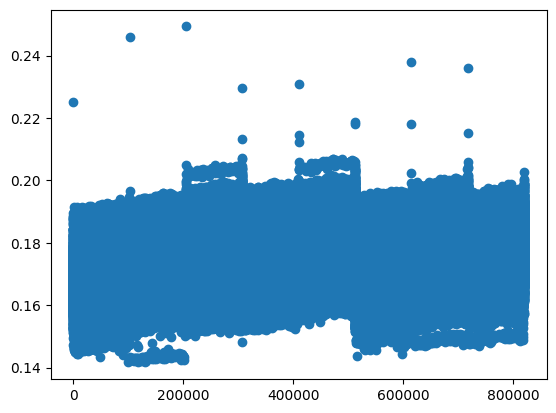

In [38]:
plt.scatter(list(range(1, y_voltage.flatten().shape[0]  + 1)), y_voltage.flatten())

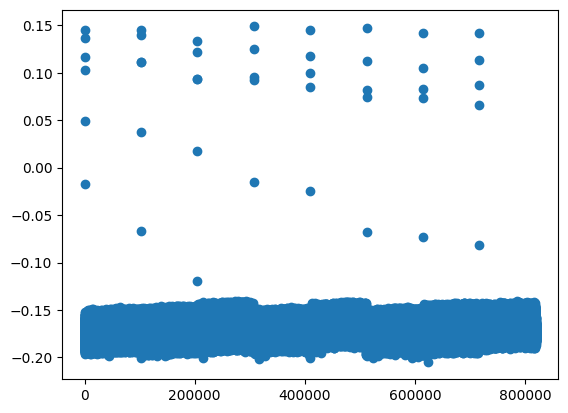

In [39]:
plt.scatter(list(range(1, x_voltage.flatten().shape[0]  + 1)), x_voltage.flatten())

In [40]:
x_voltage = np.mean(x_voltage, axis = 2)
y_voltage = np.mean(y_voltage, axis = 2)

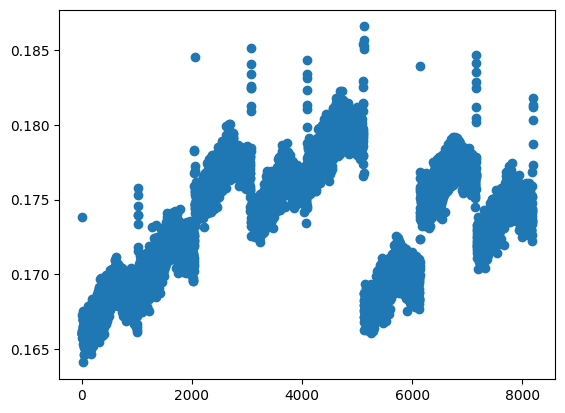

In [41]:
plt.scatter(list(range(1, y_voltage.flatten().shape[0]  + 1)), y_voltage.flatten())

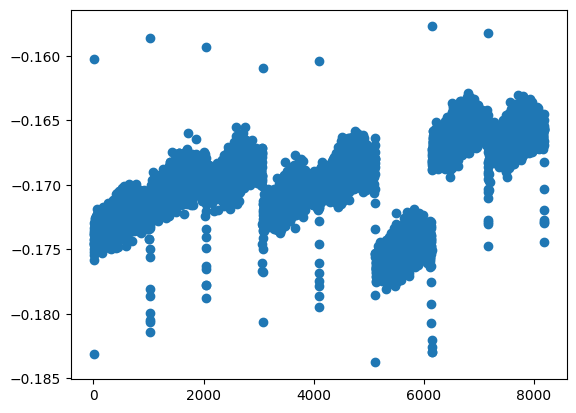

In [42]:
plt.scatter(list(range(1, x_voltage.flatten().shape[0]  + 1)), x_voltage.flatten())

In [43]:
x_voltage = x_voltage[0].flatten()
y_voltage = y_voltage[0].flatten()

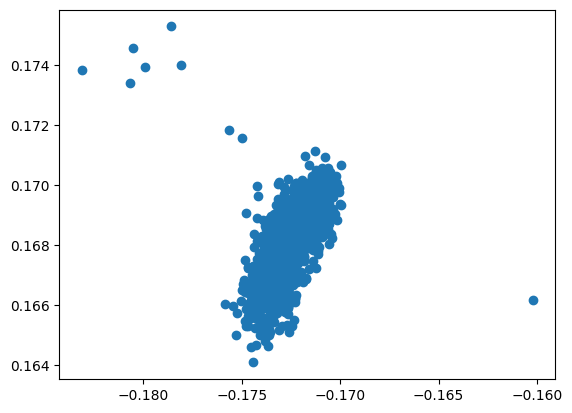

In [44]:
plt.scatter(x_voltage, y_voltage)

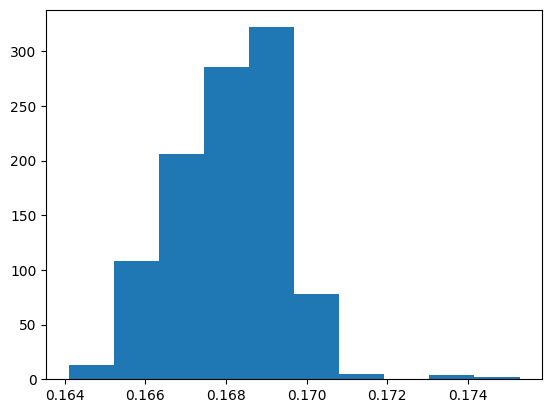

In [45]:
plt.hist(y_voltage)
z_scores_x = np.abs((x_voltage - np.mean(x_voltage)) / np.std(x_voltage))
z_scores_y = np.abs((y_voltage - np.mean(y_voltage)) / np.std(y_voltage))

threshold = 3

filtered_indices = (z_scores_x < threshold) & (z_scores_y < threshold)
x_voltage = x_voltage[filtered_indices]
y_voltage = y_voltage[filtered_indices]

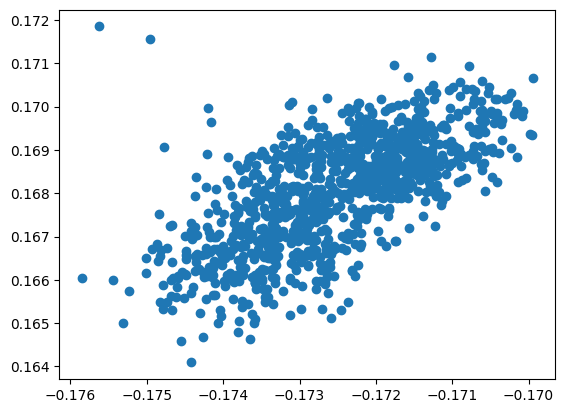

In [46]:
plt.scatter(x_voltage, y_voltage)

In [59]:
N = -14
rad = 2 ** N

x_voltage_int = scalar_to_interval_vec(x_voltage, rad)
y_voltage_int = scalar_to_interval_vec(y_voltage, rad)

In [60]:
x_voltage_int_flatten = x_voltage_int.flatten()
y_voltage_int_flatten = y_voltage_int.flatten()

In [61]:
a_1 = ternary_search(estimate_a, 0, 1, 1e-3)
a_1, estimate_a(a_1),

(0.34278228893567897, mpf('-0.919629440260532562156191284788837551121'))

In [62]:
t_1 = ternary_search(estimate_t, -4, 0, 1e-3)
t_1, estimate_t(t_1),

(-1.014672174258512, mpf('-0.924678077162310113181913694699541018367'))

In [63]:
a_2 = ternary_search(estimate_a_mode, -4, 4, 1e-3)
a_2, estimate_a_mode(a_2)

KeyboardInterrupt: 

In [ ]:
t_2 = ternary_search(estimate_t_mode, -4, 0, 1e-3)
t_2, estimate_t_mode(t_2)

In [ ]:
a_3 = ternary_search(estimate_a_med_p, -4, 4, 1e-3)
a_3, estimate_a_med_p(a_3)

In [ ]:
t_3 = ternary_search(estimate_t_med_p, -4, 0, 1e-3)
t_3, estimate_t_med_p(t_3)

In [ ]:
a_4 = ternary_search(estimate_a_med_k, -4, 4, 1e-3)
a_4, estimate_a_med_k(a_4)

In [ ]:
t_4 = ternary_search(estimate_t_med_k, -4, 0, 1e-3)
t_4, estimate_t_med_k(t_4)